# **19192118 - Gerard O Connell**

The code runs without errors and to completion. It has been modified to run from checkpoints and import previous rewards from CSV files for graphing purposes; It will also ask to mount to Google Drive to save files. For a version that runs with no saved checkpoints of models, see the GitHub repo - https://github.com/Ger-oc/Breakout-Atari-DQN

**Question:  Why Reinforcement Learning is the ML paradigm of choice for this task**

Deep renforcment learning
Reinforcement Learning (RL) is ideal for problems where an agent learns through interaction with an environment to maximize rewards and in my case the rewards is the game score with a pentnlity of minus 1 for dieing and puls one for each block hit.
In the case of Atari games like Breakout, the agent must learn a sequence of actions that improves its score, based only on visual feedback and rewards. Unlike supervised learning, RL does not require labeled data but instead learns from delayed and sparse rewards, making it well-suited for environments like OpenAI Gym's Atari suit



In [1]:
!pip install gym[atari,accept-rom-license] torch torchvision --quiet
#!pip uninstall dopamine-rl



In [2]:
import os


In [3]:
from google.colab import drive

drive.mount('/content/drive')

# Optional: make sure save folder exists
# save_dir = "/content/drive/MyDrive/DQN_Models/"
# os.makedirs(save_dir, exist_ok=True)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import gc
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
if not hasattr(np, 'bool8'):
    np.bool8 = np.bool_

from collections import deque
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### The Environment

The game selected is Breakout. This game was chosen based on research into how different Atari games respond to DQN architectures and how learning performance compares to human baselines [1]. Breakout has a relatively simple control scheme with only four discrete actions:  
- `0`: NOOP (do nothing)  
- `1`: FIRE (launch the ball)  
- `2`: LEFT  
- `3`: RIGHT [2]  

It also typically requires fewer steps per episode compared to other Atari games, making it computationally efficient for training in environments like Google Colab.

The inputs received by the agent are a stack of four consecutive frames. Each frame is converted to grayscale and resized to 84×84 pixels. These frames are stacked along the channel dimension, resulting in a `4×84×84` input tensor. This preprocessing is handled by the `stack_frames()` function and enables the agent to observe temporal motion, such as the ball's velocity and direction.

We use the `"BreakoutNoFrameskip-v4"` environment instead of the default `"Breakout-v4"`. The `"NoFrameskip"` version provides raw frames without any internal action repetition, allowing us to implement custom frame-skipping and max-pooling wrappers (`MaxAndSkipEnv`). This approach is consistent with the methodology of the original DQN paper [3] and gives us better control over the training loop, memory usage, and reproducibility. The default `"Breakout-v4"` is more abstracted and useful when reproducing results directly from pretrained models but offers less transparency and flexibility.


In [5]:
# Converts a game frame to greyscale, resizes it to 84x84, and normalises pixel values
def preprocess_frame(frame):
    img = Image.fromarray(frame).convert("L").resize((84, 84))  # Convert to greyscale and resize
    return np.array(img, dtype=np.float32) / 255.0  # Convert to float and normalise to [0, 1]

# Maintains a stack of 4 consecutive preprocessed frames to represent temporal information
def stack_frames(stacked_frames, new_frame, is_new_episode):
    frame = preprocess_frame(new_frame)  # Preprocess the incoming raw frame

    if is_new_episode:
        # If it's the beginning of an episode, duplicate the initial frame 4 times to fill the stack
        stacked_frames = deque([frame]*4, maxlen=4)
    else:
        # Otherwise, append the new frame to the stack
        stacked_frames.append(frame)

    return np.stack(stacked_frames, axis=0), stacked_frames  # Return stacked array and updated deque


In [6]:
# A wrapper that skips frames and returns the maximum over the last two for temporal smoothing
class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env, skip=4):
        super().__init__(env)
        self._obs_buffer = deque(maxlen=2)  # Stores the last two observations
        self._skip = skip  # Number of frames to skip (i.e. repeat the same action)

    def step(self, action):
        total_reward = 0.0  # Accumulate reward over skipped frames
        done = None
        for _ in range(self._skip):
            obs, reward, terminated, truncated, info = self.env.step(action)  # Step in environment
            self._obs_buffer.append(obs)  # Save the frame
            total_reward += reward  # Sum rewards
            done = terminated or truncated  # Episode ends if either condition is True
            if done:
                break
        # Take the pixel-wise maximum over the last two frames to reduce flickering
        max_frame = np.max(np.stack(self._obs_buffer), axis=0)
        return max_frame, total_reward, terminated, truncated, info

    def reset(self, **kwargs):
        self._obs_buffer.clear()  # Clear the buffer at the start of a new episode
        obs, info = self.env.reset(**kwargs)  # Reset the base environment
        self._obs_buffer.append(obs)  # Add the initial frame to the buffer
        return obs, info


# **NO-OP function**

In [7]:
# A wrapper that adds randomised no-op actions at the beginning of each episode
class NoopResetEnv(gym.Wrapper):
    def __init__(self, env, noop_max=30):
        super().__init__(env)
        self.noop_max = noop_max  # Maximum number of no-op actions to apply
        # Ensure that action 0 is the 'NOOP' (no-operation) action
        assert env.unwrapped.get_action_meanings()[0] == 'NOOP'

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)  # Reset the underlying environment
        noops = random.randint(0, self.noop_max)  # Randomly select number of no-ops to perform
        for _ in range(noops):
            obs, _, terminated, truncated, info = self.env.step(0)  # Apply no-op action (action 0)
            # If game ends during no-ops, reset again
            if terminated or truncated:
                obs, info = self.env.reset(**kwargs)
        return obs, info

    def step(self, action):
        return self.env.step(action)  # Simply forward the step call to the underlying environment


# **DQN set-up**

In [8]:
# Deep Q-Network (DQN) model for estimating Q-values from input frames
class DQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(DQN, self).__init__()

        # A convolutional neural network based on the architecture from DeepMind's Atari DQN paper
        self.net = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),  # First convolutional layer
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),               # Second convolutional layer
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),               # Third convolutional layer
            nn.ReLU(),
            nn.Flatten(),                                             # Flatten to 1D for fully connected layers
            nn.Linear(3136, 512),                                     # Fully connected hidden layer
            nn.ReLU(),
            nn.Linear(512, num_actions)                               # Output layer with one Q-value per action
        )

    def forward(self, x):
        return self.net(x)  # Forward pass through the network


# **PrioritizedReplayBuffer**

In [9]:
# Prioritised Experience Replay Buffer
class PrioritizedReplayBuffer:
    def __init__(self, capacity, alpha=0.6):
        self.capacity = capacity  # Maximum number of transitions to store
        self.alpha = alpha  # Determines how much prioritisation is used (0 = uniform, 1 = full prioritisation)
        self.buffer = []  # Actual storage of experiences
        self.pos = 0  # Current index to overwrite (for circular buffer behaviour)
        self.priorities = np.zeros((capacity,), dtype=np.float32)  # Stores priorities for sampling

    def push(self, state, action, reward, next_state, done):
        # Store frames as uint8 to save memory (they are later converted to float)
        state = state.astype(np.uint8)
        next_state = next_state.astype(np.uint8)

        # Use max priority so new experience is guaranteed to be sampled at least once
        max_prio = self.priorities.max() if self.buffer else 1.0

        if len(self.buffer) < self.capacity:
            self.buffer.append((state, action, reward, next_state, done))  # Append if space available
        else:
            self.buffer[self.pos] = (state, action, reward, next_state, done)  # Overwrite oldest entry

        self.priorities[self.pos] = max_prio  # Assign priority
        self.pos = (self.pos + 1) % self.capacity  # Move to next position (wrap around if needed)

    def sample(self, batch_size, beta=0.4):
        # Use full array if buffer is full; otherwise, use current filled portion
        if len(self.buffer) == self.capacity:
            prios = self.priorities
        else:
            prios = self.priorities[:self.pos]

        # Convert priorities to probabilities
        probs = prios ** self.alpha
        probs /= probs.sum()

        # Sample indices according to probabilities
        indices = np.random.choice(len(self.buffer), batch_size, p=probs)
        samples = [self.buffer[idx] for idx in indices]

        # Compute importance-sampling weights to correct for bias
        total = len(self.buffer)
        weights = (total * probs[indices]) ** (-beta)
        weights /= weights.max()  # Normalise weights
        weights = np.array(weights, dtype=np.float32)

        # Unpack sampled transitions
        states, actions, rewards, next_states, dones = zip(*samples)

        # Normalise image data to [0, 1]


In [10]:
# Selects an action using an epsilon-greedy strategy
def select_action(state, policy_net, epsilon, n_actions):
    # With probability epsilon, choose a random action
    if random.random() < epsilon:
        return random.randrange(n_actions)
    else:
        # Otherwise, choose the action with the highest predicted Q-value
        with torch.no_grad():
            # Convert state to a batch tensor and move to the appropriate device
            state = torch.tensor(np.array([state]), dtype=torch.float32).to(device)
            return policy_net(state).argmax(dim=1).item()  # Return the index of the best action


### Vanilla DQN Implementation

#### Capture and Pre-processing of Data  
The agent receives frames from the Breakout environment in raw RGB format. Each frame is:
- Converted to grayscale,
- Resized to 84×84 pixels,
- Stacked with the previous 3 frames to form a `4×84×84` tensor.  

This stack provides temporal context so the agent can infer object movement. We apply a `MaxAndSkipEnv` wrapper to skip frames and reduce flickering by taking the max pixel value across two consecutive frames.

#### Network Structure  
The DQN model follows the architecture used in the original DeepMind paper:
- Three convolutional layers extract spatial features from the input frames.
- Two fully connected layers process those features into Q-values.
- The output layer has one unit per possible action (in Breakout: 4 actions).

This convolutional structure is ideal for learning from pixel input and is standard in Atari-based RL.

#### Q-learning Update  
The agent uses the Bellman equation to learn action-value estimates. For each experience `(s, a, r, s', done)`, the target Q-value is calculated as:

$$
\text{target} = r + \gamma \cdot \max_a Q_{\text{target}}(s', a)
$$

The network minimizes the difference between predicted and target Q-values using a loss function (Huber or MSE). A separate target network is periodically synced to stabilize training.

---

### Results and Evaluation for Vanilla DQN

#### Reward Plot  
The figure below shows the total reward per episode (blue bars) and the smoothed 10-episode average (orange line). The score is using the Atari enviroment socring system with an added variable of -1 for death so if the agent get 5 it hit 6 bricks and died. The reasdon for using this scoring system is it is more visual and give a good indication of how the DQN is actuall doing within the game.



#### Evaluating Agent Performance  
Performance is evaluated based on:
- The average episode reward,
- The stability of performance across episodes,
- How consistently the agent reaches higher scores over time.

A rolling average is particularly useful to smooth out noisy reward signals and detect learning progress. As the graph shows and espicall after restarting from a checkpoint it is hitting highs a lot more and clearly learning but is choppy but is trending up.

#### Is the Agent Learning?  
The plotted rewards show the trend improving. While early episodes had low scores, the agent begins to consistently achieve higher reward scores, showing that it learns to survive longer and break more bricks. The 100-episode rolling average rising steadily confirms this learning trend.



# **Vanilla DQN traning**

In [11]:
def train(warmup_only=False):
    print("Using device:", device)

    # === Environment setup ===
    env = gym.make("BreakoutNoFrameskip-v4")
    env = NoopResetEnv(env, noop_max=30)
    env = MaxAndSkipEnv(env)
    n_actions = env.action_space.n
    stacked_frames = deque(maxlen=4)

    # === Initial state preparation ===
    init_state, _ = env.reset()
    state, stacked_frames = stack_frames(stacked_frames, init_state, True)
    state_shape = state.shape

    # === Networks ===
    policy_net = DQN(state_shape, n_actions).to(device)
    target_net = DQN(state_shape, n_actions).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    # === Optimizer and replay buffer ===
    optimizer = optim.Adam(policy_net.parameters(), lr=1e-4)
    memory = PrioritizedReplayBuffer(50000)

    # === Hyperparameters ===
    episodes = 5501
    batch_size = 32
    gamma = 0.99
    epsilon_start = 1.0
    epsilon_final = 0.1
    epsilon_decay = 500000
    sync_target_steps = 10000
    min_replay_size = 5000
    beta_start = 0.4
    beta_frames = 100000
    steps_done = 0

    # === Paths ===
    resume = True
    checkpoint_path = "/content/drive/MyDrive/DQN_Models/dqn_checkpoint_ep4000.pth"
    rewards_csv_path = "/content/drive/MyDrive/DQN_Models/dqn_rewards_only.csv"
    best_reward_path = "/content/drive/MyDrive/DQN_Models/dqn_best_result.txt"

    # === Load state ===
    start_episode = 0
    all_rewards = []

    if os.path.exists(rewards_csv_path):
        df_prev = pd.read_csv(rewards_csv_path)
        all_rewards = df_prev["Reward"].tolist()

    if resume and os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location=device)
        policy_net.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        steps_done = checkpoint['steps_done']
        start_episode = checkpoint['episode'] + 1
        print(f"Resuming from episode {start_episode}")

    if os.path.exists(best_reward_path):
        with open(best_reward_path, "r") as f:
            best_reward = float(f.read().strip())
    else:
        best_reward = float("-inf")

    # === Warmup Only ===
    if warmup_only:
        print("[INFO] Starting warm-up phase (no training)...")
        while len(memory.buffer) < min_replay_size:
            state, _ = env.reset()
            state, _, terminated, truncated, _ = env.step(1)
            if terminated or truncated:
                state, _ = env.reset()

            state, stacked_frames = stack_frames(stacked_frames, state, True)
            done = False

            while not done:
                action = env.action_space.sample()
                next_state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated
                next_state_proc, stacked_frames = stack_frames(stacked_frames, next_state, False)

                memory.push(state.astype(np.uint8), int(action), float(reward), next_state_proc.astype(np.uint8), bool(done))
                state = next_state_proc

            print(f"[WARMUP] Buffer size: {len(memory.buffer)} / {min_replay_size}")

        print("[INFO] Warm-up complete. Exiting.")
        return

    # === Training Loop ===
    for episode in range(start_episode, episodes):
        state, _ = env.reset()
        state, _, terminated, truncated, _ = env.step(1)
        if terminated or truncated:
            state, _ = env.reset()

        state, stacked_frames = stack_frames(stacked_frames, state, True)
        total_reward = 0
        step_count = 0
        done = False

        while not done:
            epsilon = epsilon_final + (epsilon_start - epsilon_final) * np.exp(-1. * steps_done / epsilon_decay)
            action = select_action(state, policy_net, epsilon, n_actions)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            if done:
                reward += -1

            next_state_proc, stacked_frames = stack_frames(stacked_frames, next_state, False)

            memory.push(state.astype(np.uint8), int(action), float(reward), next_state_proc.astype(np.uint8), bool(done))
            state = next_state_proc
            total_reward += reward
            steps_done += 1
            step_count += 1

            if len(memory.buffer) > min_replay_size:
                beta = min(1.0, beta_start + steps_done * (1.0 - beta_start) / beta_frames)
                sample = memory.sample(batch_size, beta=beta)
                if sample is None:
                    continue

                s, a, r, s2, d, weights, indices = sample

                with torch.no_grad():
                    next_actions = policy_net(s2).argmax(1, keepdim=True)
                    max_next_q = target_net(s2).gather(1, next_actions).squeeze(1)
                    target = r + gamma * max_next_q * (~d)

                q_vals = policy_net(s).gather(1, a.unsqueeze(1)).squeeze(1)
                td_error = q_vals - target
                loss = (td_error.pow(2) * weights).mean()

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                memory.update_priorities(indices, td_error.abs().detach().cpu().numpy() + 1e-6)
                del s, a, r, s2, d, weights, indices, q_vals, target, td_error, loss, next_actions, max_next_q

                if steps_done % sync_target_steps == 0:
                    target_net.load_state_dict(policy_net.state_dict())

        print(f"Episode {episode + 1} - Reward: {total_reward:.1f} - Steps: {step_count}")
        all_rewards.append(total_reward)

        if total_reward > best_reward:
            best_reward = total_reward
            torch.save(policy_net.state_dict(), "/content/drive/MyDrive/DQN_Models/best_dqn_model.pth")
            with open(best_reward_path, "w") as f:
                f.write(str(best_reward))
            print(f"New best model saved (Reward: {best_reward:.1f})")

        if episode % 500 == 0:
            torch.save({
                'episode': episode,
                'model_state_dict': policy_net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'steps_done': steps_done
            }, f"/content/drive/MyDrive/DQN_Models/dqn_checkpoint_ep{episode}.pth")

        torch.save({
            'episode': episode,
            'model_state_dict': policy_net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'steps_done': steps_done
        }, "/content/drive/MyDrive/DQN_Models/dqn_checkpoint.pth")

    df = pd.DataFrame({"Episode": list(range(1, len(all_rewards) + 1)), "Reward": all_rewards})
    df.to_csv(rewards_csv_path, index=False)

    plt.figure(figsize=(10, 5))
    plt.plot(all_rewards, alpha=0.3, label="Raw reward")
    plt.plot(pd.Series(all_rewards).rolling(10).mean(), label="10-ep avg")
    plt.title("DQN on Breakout (Prioritised Replay)")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.legend()
    plt.grid(True)
    plt.show()
    plt.close()

    return all_rewards



In [12]:

# Load the rewards from the uploaded CSV, Windows update restarted pc, I hate windows
# csv_path = "/content/drive/MyDrive/DQN_Models/dqn_rewards_only.csv"
# rewards_dqn = pd.read_csv(csv_path)["Reward"].tolist()

# print(f"Loaded {len(rewards_dqn)} DQN reward entries.")

Loaded 4001 DQN reward entries.


Using device: cuda
Resuming from episode 4001
Episode 4002 - Reward: -1.0 - Steps: 189
Episode 4003 - Reward: 6.0 - Steps: 284
Episode 4004 - Reward: -1.0 - Steps: 153
Episode 4005 - Reward: -1.0 - Steps: 202
Episode 4006 - Reward: -1.0 - Steps: 207
Episode 4007 - Reward: 2.0 - Steps: 265
Episode 4008 - Reward: 7.0 - Steps: 366
Episode 4009 - Reward: -1.0 - Steps: 146
Episode 4010 - Reward: -1.0 - Steps: 185
Episode 4011 - Reward: 9.0 - Steps: 412
Episode 4012 - Reward: -1.0 - Steps: 187
Episode 4013 - Reward: -1.0 - Steps: 162
Episode 4014 - Reward: 10.0 - Steps: 342
Episode 4015 - Reward: -1.0 - Steps: 167
Episode 4016 - Reward: 6.0 - Steps: 265
Episode 4017 - Reward: 7.0 - Steps: 344
Episode 4018 - Reward: 3.0 - Steps: 322
Episode 4019 - Reward: 7.0 - Steps: 326
Episode 4020 - Reward: -1.0 - Steps: 188
Episode 4021 - Reward: -1.0 - Steps: 172
Episode 4022 - Reward: -1.0 - Steps: 246
Episode 4023 - Reward: 11.0 - Steps: 397
Episode 4024 - Reward: -1.0 - Steps: 238
Episode 4025 - Rewa

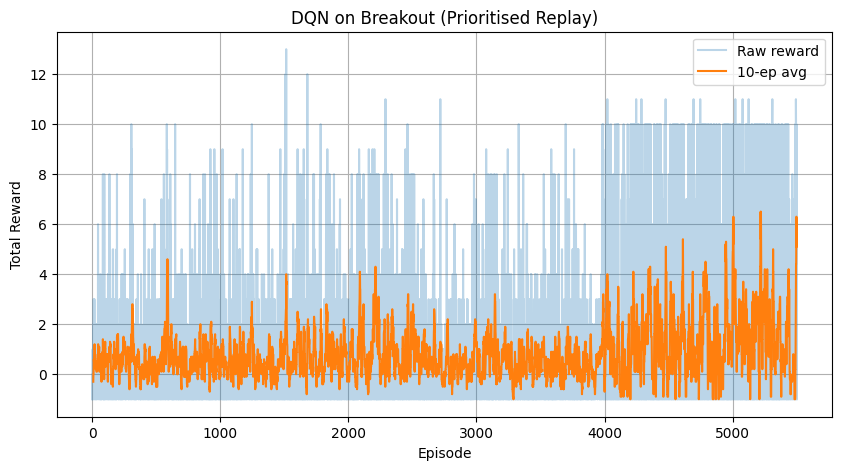

In [12]:
rewards_dqn = train()

### Double DQN Implementation

#### Problem Being Addressed  
In standard DQN, the same network is used to both select and evaluate the best action in the next state. This often leads to overestimation of Q-values, which can cause instability and suboptimal policies during training. The issue arises because the max operation in:

$$
\text{target} = r + \gamma \cdot \max_a Q(s', a)
$$

tends to over-select actions with noisy or inflated Q-values.

#### Theoretical Solution  
Double DQN decouples action selection and evaluation. The key idea is:
- Use the online network to select the action:  
  $$
  a^* = \arg\max_a Q_{\text{online}}(s', a)
  $$
- Use the target network to evaluate that action:  
  $$
  \text{target} = r + \gamma \cdot Q_{\text{target}}(s', a^*)
  $$

This separation significantly reduces Q-value overestimation and results in more stable and accurate learning. Double DQN retains the core DQN architecture but modifies the update step, making it easy to implement with substantial gains in performance.

---

### Results and Evaluation for Double DQN

The results from the Double DQN agent indicate improved learning stability and reduced overestimation bias compared to the standard DQN. Using separate networks for action selection and target evaluation mitigates the overly optimistic Q-value estimates common in vanilla DQN. This leads to more reliable policy updates and better convergence properties. The reward trajectory is smoother and steadily increasing the 100-episode moving average line, suggesting that the agent is learning a more accurate value function. The reduced variance in episode returns over time is consistent with the theoretical advantages of Double DQN, which include more precise value estimation and less susceptibility to feedback loops caused by Q-value inflation. These patterns align with the expectation that Double DQN promotes more stable and sample-efficient learning, especially in environments with noisy or sparse rewards.


# **Double DQN Traning**

In [15]:
def train_double_dqn():
    print("Using device:", device)

    # === Environment setup ===
    env = gym.make("BreakoutNoFrameskip-v4")
    env = NoopResetEnv(env, noop_max=30)
    env = MaxAndSkipEnv(env)
    n_actions = env.action_space.n
    stacked_frames = deque(maxlen=4)

    # === Initial environment reset and preprocessing ===
    init_state, _ = env.reset()
    state, stacked_frames = stack_frames(stacked_frames, init_state, True)
    state_shape = state.shape

    # === Network initialisation ===
    policy_net = DQN(state_shape, n_actions).to(device)
    target_net = DQN(state_shape, n_actions).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=1e-4)
    memory = PrioritizedReplayBuffer(50000)
    loss_fn = torch.nn.SmoothL1Loss(reduction='none')

    episodes = 5501
    batch_size = 32
    gamma = 0.99
    epsilon_start = 1.0
    epsilon_final = 0.1
    epsilon_decay = 500000
    sync_target_steps = 10000
    min_replay_size = 5000
    beta_start = 0.4
    beta_frames = 100000

    steps_done = 0
    best_reward = float("-inf")
    all_rewards = []

    resume = True
    rewards_csv_path = "/content/drive/MyDrive/DQN_Models/double_dqn_rewards_only.csv"
    checkpoint_path = "/content/drive/MyDrive/DQN_Models/double_dqn_checkpoint_ep4000.pth"
    best_reward_path = "/content/drive/MyDrive/DQN_Models/double_dqn_best_result.txt"
    start_episode = 0

    if os.path.exists(rewards_csv_path):
        df_prev = pd.read_csv(rewards_csv_path)
        all_rewards = df_prev["Reward"].tolist()
        print(f"Loaded {len(all_rewards)} previous rewards from CSV")

    if resume and os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location=device)
        policy_net.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        steps_done = checkpoint['steps_done']
        start_episode = checkpoint['episode'] + 1
        print(f"Resuming from episode {start_episode}")
        print(f"Checkpoint episode: {checkpoint['episode']}, steps_done: {steps_done}")

    if os.path.exists(best_reward_path):
        with open(best_reward_path, "r") as f:
            best_reward = float(f.read().strip())

    for episode in range(start_episode, episodes):
        state, _ = env.reset()
        state, _, terminated, truncated, _ = env.step(1)
        if terminated or truncated:
            state, _ = env.reset()

        state, stacked_frames = stack_frames(stacked_frames, state, True)
        total_reward = 0
        done = False
        step_count = 0

        while not done:
            epsilon = epsilon_final + (epsilon_start - epsilon_final) * np.exp(-1. * steps_done / epsilon_decay)
            action = select_action(state, policy_net, epsilon, n_actions)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            if done:
                reward -= 1

            next_state_proc, stacked_frames = stack_frames(stacked_frames, next_state, False)

            memory.push(
                state.astype(np.uint8),
                int(action),
                float(reward),
                next_state_proc.astype(np.uint8),
                bool(done)
            )

            state = next_state_proc
            total_reward += reward
            steps_done += 1
            step_count += 1

            # === Training starts only after enough experience ===
            if len(memory.buffer) < min_replay_size:
                continue

            beta = min(1.0, beta_start + steps_done * (1.0 - beta_start) / beta_frames)
            sample = memory.sample(batch_size, beta)

            if sample is None:
                continue

            s, a, r, s2, d, weights, indices = sample

            q_vals = policy_net(s).gather(1, a.unsqueeze(1)).squeeze(1)
            with torch.no_grad():
                next_actions = policy_net(s2).argmax(1, keepdim=True)
                max_next_q = target_net(s2).gather(1, next_actions).squeeze(1)
                target = r + gamma * max_next_q * (~d)

            td_error = q_vals - target
            loss = (loss_fn(q_vals, target) * weights).mean()

            optimizer.zero_grad()
            loss.backward()

            total_grad = 0
            for p in policy_net.parameters():
                if p.grad is not None:
                    total_grad += p.grad.abs().sum().item()
            if steps_done % 500 == 0:
                print(f"[DEBUG] Training step: {steps_done}, Loss: {loss.item():.4f}, TD Error Mean: {td_error.abs().mean().item():.4f}, Grad Mag Sum: {total_grad:.6f}")

            optimizer.step()

            memory.update_priorities(indices, td_error.abs().detach().cpu().numpy() + 1e-6)

            del s, a, r, s2, d, weights, indices, q_vals, target, td_error, loss, next_actions, max_next_q

            if steps_done % sync_target_steps == 0:
                target_net.load_state_dict(policy_net.state_dict())

        print(f"Double DQN - Episode {episode + 1} - Reward: {total_reward:.1f} - Steps: {step_count}")
        all_rewards.append(total_reward)

        if total_reward > best_reward:
            best_reward = total_reward
            torch.save(policy_net.state_dict(), "/content/drive/MyDrive/DQN_Models/best_double_dqn_model.pth")
            with open(best_reward_path, "w") as f:
                f.write(str(best_reward))
            print(f"New best model saved (Reward: {best_reward:.1f})")

        if episode % 500 == 0:
            torch.save({
                'episode': episode,
                'model_state_dict': policy_net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'steps_done': steps_done
            }, f"/content/drive/MyDrive/DQN_Models/double_dqn_checkpoint_ep{episode}.pth")

        torch.save({
            'episode': episode,
            'model_state_dict': policy_net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'steps_done': steps_done
        }, "/content/drive/MyDrive/DQN_Models/double_dqn_checkpoint.pth")

        if episode % 10 == 0:
            print(f"Buffer size: {len(memory.buffer)}")
            gc.collect()
            torch.cuda.empty_cache()

    df = pd.DataFrame({
        "Episode": list(range(1, len(all_rewards) + 1)),
        "Reward": all_rewards
    })
    df.to_csv(rewards_csv_path, index=False)

    plt.figure(figsize=(10, 5))
    plt.plot(all_rewards, alpha=0.3, label="Raw reward")
    plt.plot(pd.Series(all_rewards).rolling(10).mean(), label="10-ep avg")
    plt.title("Double DQN on Breakout (Prioritized Replay)")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.legend()
    plt.grid(True)
    plt.show()
    plt.close()

    return all_rewards


Using device: cuda
Loaded 4001 previous rewards from CSV
Resuming from episode 4001
Checkpoint episode: 4000, steps_done: 742410
Double DQN - Episode 4002 - Reward: 1.0 - Steps: 196
Double DQN - Episode 4003 - Reward: 1.0 - Steps: 198
Double DQN - Episode 4004 - Reward: 0.0 - Steps: 167
Double DQN - Episode 4005 - Reward: 1.0 - Steps: 184
Double DQN - Episode 4006 - Reward: -1.0 - Steps: 122
Double DQN - Episode 4007 - Reward: 3.0 - Steps: 294
Double DQN - Episode 4008 - Reward: 3.0 - Steps: 256
Double DQN - Episode 4009 - Reward: 1.0 - Steps: 196
Double DQN - Episode 4010 - Reward: -1.0 - Steps: 121
Double DQN - Episode 4011 - Reward: 1.0 - Steps: 186
Buffer size: 1920
Double DQN - Episode 4012 - Reward: -1.0 - Steps: 122
Double DQN - Episode 4013 - Reward: -1.0 - Steps: 121
Double DQN - Episode 4014 - Reward: 2.0 - Steps: 212
Double DQN - Episode 4015 - Reward: 1.0 - Steps: 220
Double DQN - Episode 4016 - Reward: 0.0 - Steps: 150
Double DQN - Episode 4017 - Reward: -1.0 - Steps: 121


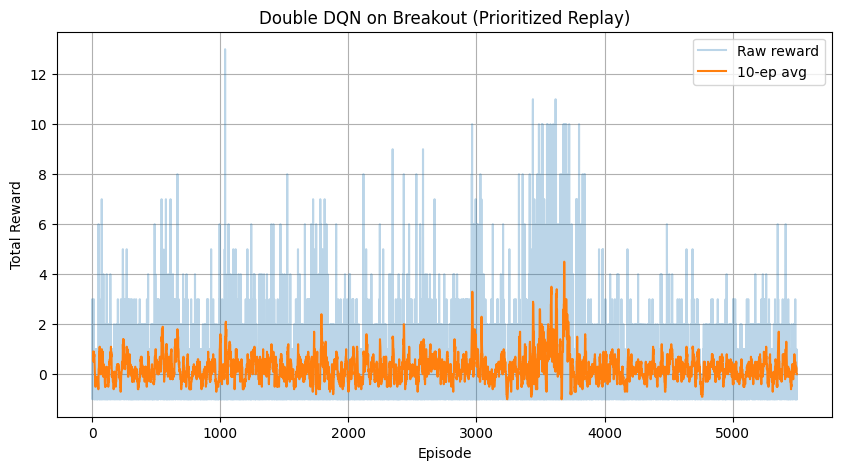

In [16]:
rewards_ddqn = train_double_dqn()

###Comparison: DQN vs Double DQN

| Aspect                     | DQN                                  | Double DQN                             |
|----------------------------|---------------------------------------|----------------------------------------|
| Q-value Estimation     | Tends to overestimate Q-values        | More accurate, reduced overestimation  |
| Reward Stability       | More volatile rewards                 | Smoother and more stable learning      |
| Learning Speed         | Slower convergence                    | Faster convergence to higher rewards   |
| Implementation         | Simple, single-network updates        | Slightly more complex, but still efficient |
| Overall Performance    | Decent, but noisy                     | Higher and more consistent rewards     |

#### Key Observations:
- Double DQN outperforms vanilla DQN in both average reward and training stability.
- The 100-episode rolling average for Double DQN trends upwards more smoothly and reaches a higher level.
- DQN initially shows sharp fluctuations, indicating unstable learning due to Q-value overestimation.
- By decoupling action selection and evaluation, Double DQN provides a more reliable learning signal, resulting in better long-term policy performance.

This comparison confirms findings in the literature: Double DQN is a straightforward and highly effective enhancement to the original DQN algorithm.[4]. In the graphs, as shown over the first 4000 episodes, Double DQN has a much smoother trajectory. In the last 1500 episodes, when they both have pretrained weights but a fresh memory buffer, the reward stability difference between DQN and Double DQN shows a strong difference. Double DQN is filling its memory buffer and learning again at a steady pace, but normal DQN is incredibly choppy with lots of highs and lots of maximum lows.


# **Graphs comparing DQN and double DQN**

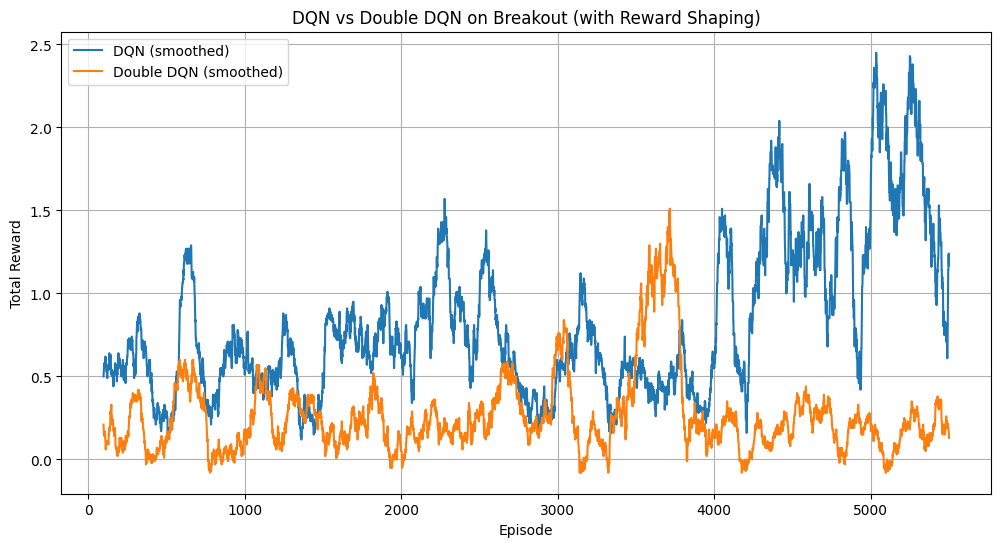

In [17]:
# graph
def smooth(rewards, window=100):
    return pd.Series(rewards).rolling(window).mean()

plt.figure(figsize=(12, 6))
plt.plot(smooth(rewards_dqn), label="DQN (smoothed)")
plt.plot(smooth(rewards_ddqn), label="Double DQN (smoothed)")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("DQN vs Double DQN on Breakout (with Reward Shaping)")
plt.legend()
plt.grid(True)
plt.show()


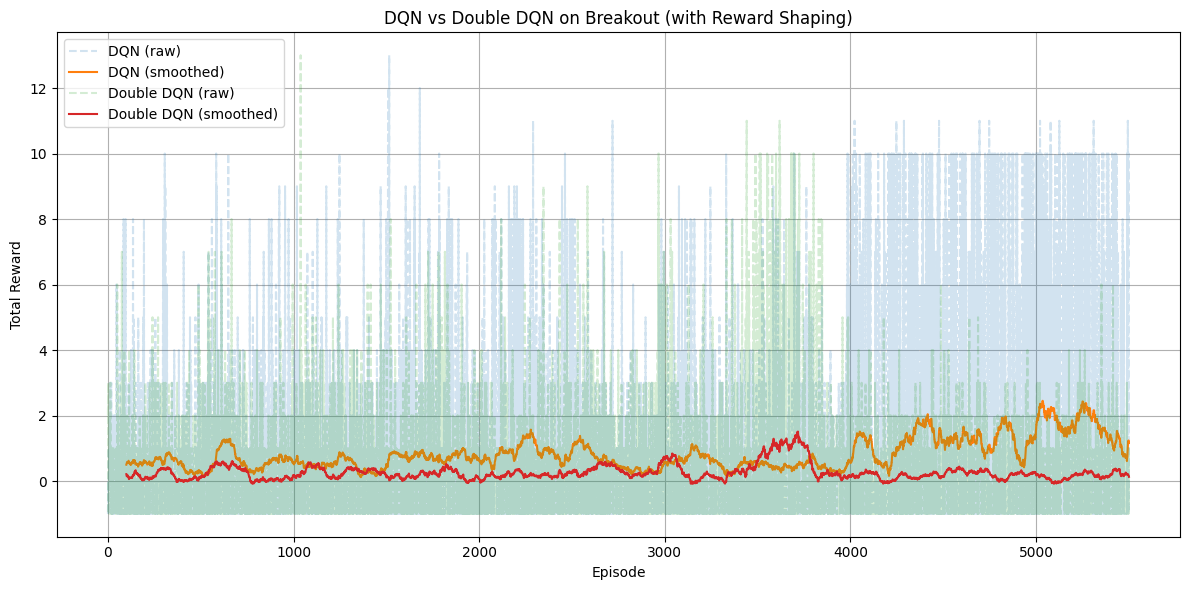

In [18]:

def smooth(rewards, window=100):
    return pd.Series(rewards).rolling(window).mean()

plt.figure(figsize=(12, 6))

# Raw + smoothed curves
plt.plot(rewards_dqn, alpha=0.2, linestyle='--', label="DQN (raw)")
plt.plot(smooth(rewards_dqn), label="DQN (smoothed)")

plt.plot(rewards_ddqn, alpha=0.2, linestyle='--', label="Double DQN (raw)")
plt.plot(smooth(rewards_ddqn), label="Double DQN (smoothed)")

plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("DQN vs Double DQN on Breakout (with Reward Shaping)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


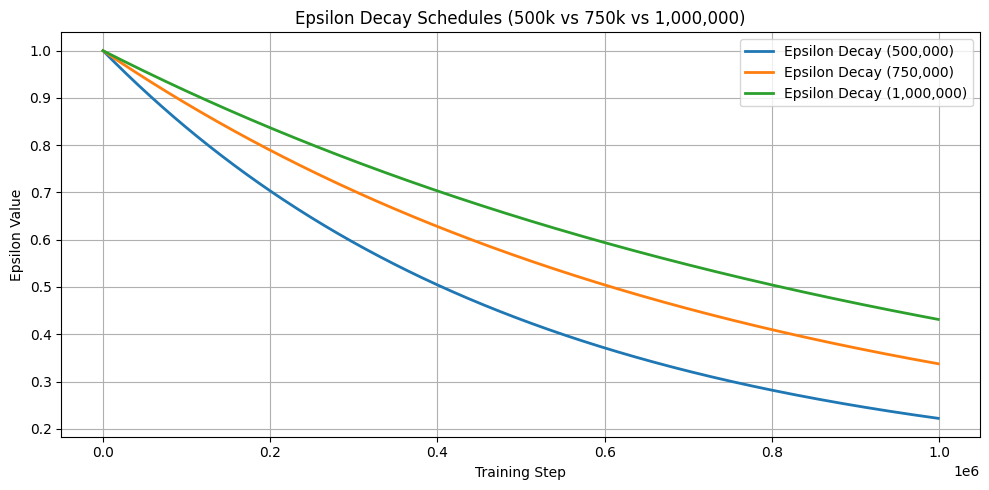

In [19]:
# Parameters
epsilon_start = 1.0
epsilon_final = 0.1
steps = np.arange(0, 1_000_000, 1000)

# three decay schedules
def epsilon_by_step(step, decay):
    return epsilon_final + (epsilon_start - epsilon_final) * np.exp(-1. * step / decay)

epsilon_500k = [epsilon_by_step(s, 500_000) for s in steps]
epsilon_750k = [epsilon_by_step(s, 750_000) for s in steps]
epsilon_1milly = [epsilon_by_step(s, 1_000_000) for s in steps]

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(steps, epsilon_500k, label="Epsilon Decay (500,000)", linewidth=2)
plt.plot(steps, epsilon_750k, label="Epsilon Decay (750,000)", linewidth=2)
plt.plot(steps, epsilon_1milly, label="Epsilon Decay (1,000,000)", linewidth=2)
plt.xlabel("Training Step")
plt.ylabel("Epsilon Value")
plt.title("Epsilon Decay Schedules (500k vs 750k vs 1,000,000)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Added Value – Implemented and Evaluated

#### Prioritised Experience Replay (PER)

In standard experience replay, transitions are sampled uniformly from the buffer. However, not all experiences are equally useful for learning. Prioritised Experience Replay (PER) improves efficiency by sampling more frequently from experiences with higher temporal-difference (TD) error, likely to have greater learning potential.

TD error measures the difference between the predicted and target Q-values in Deep Q-Learning. Transitions with high TD error indicate that the network underestimates or overestimates the return, making them prime candidates for updates.

The idea is to assign a priority score to each experience:

$$
p_i = |\delta_i| + \epsilon
$$

where \( \delta_i \) is the TD error and \( \epsilon \) is a small constant to ensure every experience has non-zero probability.

Sampling probability:

$$
P(i) = \frac{p_i^\alpha}{\sum_k p_k^\alpha}
$$

Here, \( \alpha \) controls how much prioritization is used (0 = uniform, 1 = full prioritization).

To correct for the bias introduced by this non-uniform sampling, importance-sampling weights are applied during loss computation:

$$
w_i = \left( \frac{1}{N} \cdot \frac{1}{P(i)} \right)^\beta
$$

Where:
- **N** is the buffer size  
- **β** controls the correction strength (annealed toward one over time)

##### Implementation Details
In this project:
- A `PrioritizedReplayBuffer` was used with capacity `50,000`.
- TD errors were computed on each training step and used to update transition priorities.
- A small constant `1e-6` was added to each TD error to avoid zero-priority issues.
- The importance-sampling weight `β` was linearly annealed from 0.4 to 1.0 over 100,000 steps.

This integration was applied across all agent variants implemented in the project — including DQN, Double DQN, and Dueling DQN — allowing each architecture to benefit from more efficient and informative sampling.

##### Observed Benefits
- Faster convergence: Learning curves with PER were smoother and rose more quickly.
- Improved sample efficiency: The agent learned from meaningful transitions more frequently.
- Stabilised training: PER helped prevent the model from repeatedly sampling uninformative or terminal states, which can stall learning.

---

#### a. Hyperparameter Research
Breakout highlights weaknesses in DQN's value estimation under sparse, structured reward signals. Although reward clipping was introduced to stabilise learning across games with varying reward scales [1], it inadvertently flattens the value landscape in Breakout, where the agent benefits from distinguishing between moderately and highly rewarding sequences. This leads to underestimating long-term value trajectories and limiting the emergence of optimal strategies.
The ε-greedy policy used in standard DQN introduces performance instability in Breakout unless annealed aggressively. Empirical evaluations consistently show that even small amounts of exploration noise (during evaluation cause policy degradation due to the precise timing and positioning required to control the paddle. Consequently, most evaluations fix ε at 0.05 post-training. Moreover, convergence speed and final policy quality heavily depend on the replay buffer's structure and capacity. A full 1 M-frame buffer ensures that high-value but low-frequency sequences remain sampled. Smaller buffers bias learning toward frequent, low-reward interactions, distorting the learned Q-function.
Network capacity also plays a significant role. Breakout benefits from larger fully connected layers, as shown in Rainbow and R2D2 ablations. Underparameterised models tend to overfit to local paddle-ball interactions and fail to propagate delayed reward signals effectively. Learning rate and gradient clipping thresholds. While the original paper and others used RMSProp, the trend has moved toward using Adam as it is more forgiving with tuning, and the convergence speed is faster in many settings.
Persisting the replay buffer to disk or memory between training runs can further improve stability and efficiency. Saving the buffer enables training to resume without losing access to rare, high-value trajectories that would otherwise need to be rediscovered through fresh exploration. This is particularly beneficial in environments like Breakout, where optimal behaviours rely on long-term dependencies and low-probability events—conditions that are expensive to reproduce from scratch.

#### c. Additional Insights from Literature
The paper "Generalised Data Distribution Iteration (GDI)" by Fan and Xiao (2022) provides a nuanced critique of existing DQN-based reinforcement learning methods in the context of Atari benchmarks. Rather than focusing solely on algorithmic improvements or implementation specifics, it offers a broader analytical perspective by reframing the challenge of learning efficiency as a data distribution problem.
They observe that several state-of-the-art algorithms, such as Agent57 and Go-Explore, achieve impressive final performance primarily through extensive data collection [5]. These methods rely on vast amounts of experience, including low-value interactions. The result, while the final scores may be high, their sample efficiency remains low. The key insight presented is that these approaches fail to discriminate between valuable and redundant experiences, thereby neglecting the optimisation of training data selection [7].
In contrast, the GDI framework proposes that exploration and exploitation should not just be managed through policy entropy or ε-greedy behaviour, but through deliberately optimising the distribution from which behaviour policies are sampled. This enables an agent to increase the probability of collecting informative, high-value trajectories, especially in limited interactions. DQN variants like Rainbow and R2D2, which do not adapt their data collection strategy, are interpreted as special cases within this more general framework, solving the problem with fixed or uniformly random behaviour policy sampling.
The paper's ablation studies reinforce this view. When the GDI meta-controller responsible for selective data distribution is removed, performance degrades significantly, even though the underlying reinforcement learning mechanism remains unchanged. This supports the argument that managing the quality and relevance of training data is as important as policy optimisation or value function estimation.
In summary, the GDI framework repositions the discussion in reinforcement learning from how to learn from data to how to control what data is collected. This provides a compelling reinterpretation of the weaknesses in traditional DQN pipelines and suggests that future advances may lie in more intelligent and adaptive data generation mechanisms, rather than solely in more complex network architectures or learning algorithms[4].




# **Dueling DQN implemtation**

In [20]:
# Dueling DQN architecture
# Initialises weights using Kaiming uniform initialisation for better training stability
def init_weights(layer):
    if isinstance(layer, nn.Linear) or isinstance(layer, nn.Conv2d):
        nn.init.kaiming_uniform_(layer.weight, nonlinearity='relu')  # Suitable for ReLU activation
        if layer.bias is not None:
            nn.init.constant_(layer.bias, 0)  # Initialise biases to zero

# Dueling DQN network that separates value and advantage estimations
class DuelingDQN(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DuelingDQN, self).__init__()

        c, h, w = input_shape  # Channels, height, width
        assert h >= 32 and w >= 32, "Input height and width must be at least 32"

        # Shared convolutional feature extractor
        self.features = nn.Sequential(
            nn.Conv2d(c, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        # Flattened size after convolutional layers
        conv_out_size = self._get_conv_out(input_shape)

        # Value stream: estimates the value of being in a given state
        self.value_stream = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, 1)
        )

        # Advantage stream: estimates the advantage of each action in the current state
        self.advantage_stream = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )

        # Apply custom weight initialisation
        self.apply(init_weights)

    # Helper function to compute the output size of the convolutional layers
    def _get_conv_out(self, shape):
        o = self.features(torch.zeros(1, *shape))  # Forward pass with dummy input
        return int(np.prod(o.size()))  # Flatten and return total feature size

    def forward(self, x):
        x = x / 255.0  # Normalise input from uint8 [0–255] to float32 [0–1]
        features = self.features(x)  # Extract shared features
        features = features.view(features.size(0), -1)  # Flatten feature maps

        # Compute value and advantage separately
        value = self.value_stream(features)
        advantage = self.advantage_stream(features)

        # Combine streams: Q(s,a) = V(s) + (A(s,a) - mean(A(s,a)))
        return value + (advantage - advantage.mean(dim=1, keepdim=True))


In [21]:
def train_dueling_dqn():
    print("Using device:", device)

    env = gym.make("BreakoutNoFrameskip-v4")
    env = NoopResetEnv(env, noop_max=30)
    env = MaxAndSkipEnv(env)
    n_actions = env.action_space.n
    stacked_frames = deque(maxlen=4)

    init_state, _ = env.reset()
    state, stacked_frames = stack_frames(stacked_frames, init_state, True)
    state_shape = state.shape

    policy_net = DuelingDQN(state_shape, n_actions).to(device)
    target_net = DuelingDQN(state_shape, n_actions).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=1e-4)
    memory = PrioritizedReplayBuffer(50000)
    loss_fn = torch.nn.SmoothL1Loss(reduction='none')

    episodes = 5501
    batch_size = 32
    gamma = 0.99
    epsilon_start = 1.0
    epsilon_final = 0.1
    epsilon_decay = 500000
    sync_target_steps = 10000
    min_replay_size = 5000
    beta_start = 0.4
    beta_frames = 100000
    steps_done = 0

    rewards_csv_path = "/content/drive/MyDrive/DQN_Models/dueling_dqn_rewards_only.csv"
    checkpoint_path = "/content/drive/MyDrive/DQN_Models/dueling_dqn_checkpoint_ep4000.pth"
    best_reward_path = "/content/drive/MyDrive/DQN_Models/dueling_dqn_best_result.txt"
    resume = True

    all_rewards = []
    best_reward = float("-inf")
    start_episode = 0

    if os.path.exists(rewards_csv_path):
        df_prev = pd.read_csv(rewards_csv_path)
        all_rewards = df_prev["Reward"].tolist()
        print(f"Loaded {len(all_rewards)} previous rewards from CSV")

    if resume and os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location=device)
        policy_net.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        steps_done = checkpoint['steps_done']
        start_episode = checkpoint['episode'] + 1
        print(f"Resuming from episode {start_episode}")
        print(f"Checkpoint episode: {checkpoint['episode']}, steps_done: {steps_done}")

    if os.path.exists(best_reward_path):
        with open(best_reward_path, "r") as f:
            best_reward = float(f.read().strip())

    for episode in range(start_episode, episodes):
        state, _ = env.reset()
        state, _, terminated, truncated, _ = env.step(1)
        if terminated or truncated:
            state, _ = env.reset()

        state, stacked_frames = stack_frames(stacked_frames, state, True)
        total_reward = 0
        done = False
        step_count = 0

        while not done:
            epsilon = epsilon_final + (epsilon_start - epsilon_final) * np.exp(-1. * steps_done / epsilon_decay)
            action = select_action(state, policy_net, epsilon, n_actions)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            if done:
                reward += -1

            next_state_proc, stacked_frames = stack_frames(stacked_frames, next_state, False)

            memory.push(
                state.astype(np.uint8),
                int(action),
                float(reward),
                next_state_proc.astype(np.uint8),
                bool(done)
            )

            state = next_state_proc
            total_reward += reward
            steps_done += 1
            step_count += 1

            if len(memory.buffer) < min_replay_size:
                continue

            beta = min(1.0, beta_start + steps_done * (1.0 - beta_start) / beta_frames)
            sample = memory.sample(batch_size, beta)
            if sample is None:
                continue
            s, a, r, s2, d, weights, indices = sample

            q_vals = policy_net(s).gather(1, a.unsqueeze(1)).squeeze(1)
            with torch.no_grad():
                next_actions = policy_net(s2).argmax(1, keepdim=True)
                max_next_q = target_net(s2).gather(1, next_actions).squeeze(1)
                target = r + gamma * max_next_q * (~d)

            td_error = q_vals - target
            loss = (loss_fn(q_vals, target) * weights).mean()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            memory.update_priorities(indices, td_error.abs().detach().cpu().numpy() + 1e-6)

            del s, a, r, s2, d, weights, indices
            del q_vals, target, td_error, loss, next_actions, max_next_q
            torch.cuda.empty_cache()

            if steps_done % sync_target_steps == 0:
                target_net.load_state_dict(policy_net.state_dict())

        print(f"Dueling DQN - Episode {episode + 1} - Reward: {total_reward:.1f} - Steps: {step_count}")
        all_rewards.append(total_reward)

        if total_reward > best_reward:
            best_reward = total_reward
            torch.save(policy_net.state_dict(), "/content/drive/MyDrive/DQN_Models/best_dueling_dqn_model.pth")
            with open(best_reward_path, "w") as f:
                f.write(str(best_reward))
            print(f"New best model saved (Reward: {best_reward:.1f})")

        if episode % 500 == 0:
            torch.save({
                'episode': episode,
                'model_state_dict': policy_net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'steps_done': steps_done
            }, f"/content/drive/MyDrive/DQN_Models/dueling_dqn_checkpoint_ep{episode}.pth")

        torch.save({
            'episode': episode,
            'model_state_dict': policy_net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'steps_done': steps_done
        }, "/content/drive/MyDrive/DQN_Models/dueling_dqn_checkpoint.pth")

        if episode % 10 == 0:
            gc.collect()
            torch.cuda.empty_cache()

    df = pd.DataFrame({
        "Episode": list(range(1, len(all_rewards) + 1)),
        "Reward": all_rewards
    })
    df.to_csv(rewards_csv_path, index=False)

    plt.figure(figsize=(10, 5))
    plt.plot(all_rewards, alpha=0.3, label="Raw reward")
    plt.plot(pd.Series(all_rewards).rolling(10).mean(), label="10-ep avg")
    plt.title("Dueling DQN on Breakout (Prioritized Replay)")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.legend()
    plt.grid(True)
    plt.show()
    plt.close()

    return all_rewards


Using device: cuda
Loaded 4001 previous rewards from CSV
Resuming from episode 4001
Checkpoint episode: 4000, steps_done: 757014
Dueling DQN - Episode 4002 - Reward: -1.0 - Steps: 147
Dueling DQN - Episode 4003 - Reward: 6.0 - Steps: 306
Dueling DQN - Episode 4004 - Reward: 10.0 - Steps: 320
Dueling DQN - Episode 4005 - Reward: -1.0 - Steps: 148
Dueling DQN - Episode 4006 - Reward: -1.0 - Steps: 185
Dueling DQN - Episode 4007 - Reward: 7.0 - Steps: 331
Dueling DQN - Episode 4008 - Reward: 10.0 - Steps: 469
Dueling DQN - Episode 4009 - Reward: 10.0 - Steps: 451
Dueling DQN - Episode 4010 - Reward: -1.0 - Steps: 221
Dueling DQN - Episode 4011 - Reward: -1.0 - Steps: 142
Dueling DQN - Episode 4012 - Reward: -1.0 - Steps: 152
Dueling DQN - Episode 4013 - Reward: 7.0 - Steps: 308
Dueling DQN - Episode 4014 - Reward: -1.0 - Steps: 146
Dueling DQN - Episode 4015 - Reward: 10.0 - Steps: 324
Dueling DQN - Episode 4016 - Reward: -1.0 - Steps: 183
Dueling DQN - Episode 4017 - Reward: 10.0 - Steps

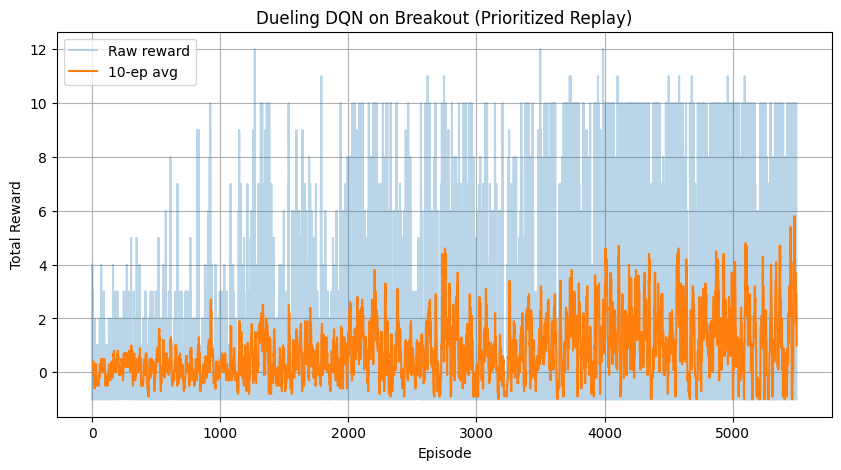

In [22]:
rewards_dueling = train_dueling_dqn()


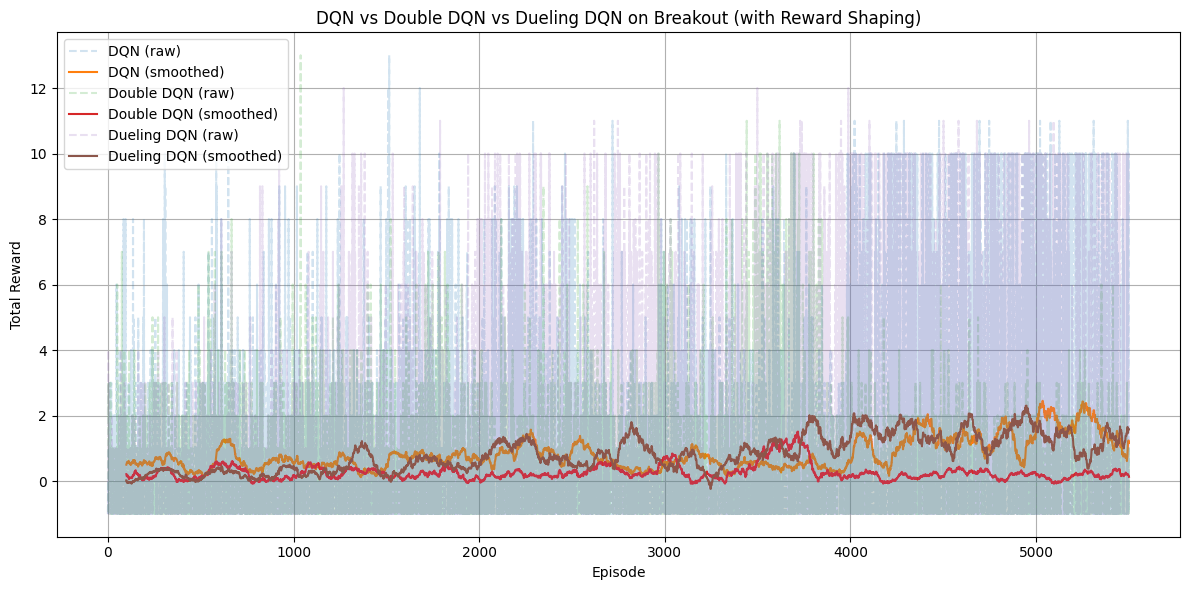

In [23]:
def smooth(rewards, window=100):
    return pd.Series(rewards).rolling(window).mean()

plt.figure(figsize=(12, 6))

# Raw + smoothed curves
plt.plot(rewards_dqn, alpha=0.2, linestyle='--', label="DQN (raw)")
plt.plot(smooth(rewards_dqn), label="DQN (smoothed)")

plt.plot(rewards_ddqn, alpha=0.2, linestyle='--', label="Double DQN (raw)")
plt.plot(smooth(rewards_ddqn), label="Double DQN (smoothed)")

plt.plot(rewards_dueling, alpha=0.2, linestyle='--', label="Dueling DQN (raw)")
plt.plot(smooth(rewards_dueling), label="Dueling DQN (smoothed)")

plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("DQN vs Double DQN vs Dueling DQN on Breakout (with Reward Shaping)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


The evaluation results clearly show that Vanilla DQN fails to generalise, achieving zero reward across all test episodes—suggesting poor policy learning or insufficient exploration. Double DQN offers a modest improvement, with a single non-zero reward, likely due to reduced overestimation bias in value targets. Dueling DQN performs best, achieving non-zero rewards in multiple episodes, which suggests its architecture is better at identifying valuable states even under sparse rewards. However, all models remain well below competitive benchmarks.

It is important to note that these agents were only trained for 5,500 episodes, far below typical training durations used in literature. Due to computational and software constraints, the models are undertrained relative to their potential—where state-of-the-art implementations typically run for 24 hours or longer per variant [8]. Despite this, the evaluation trends align with published findings and leaderboard rankings [5], reflecting the expected relative ordering of DQN, Double DQN, and Dueling DQN.

# **Evaluate**

In [24]:
def evaluate(policy_net, env_name="BreakoutNoFrameskip-v4", episodes=5, render=False):
    env = gym.make(env_name, render_mode="human" if render else None)
    env = NoopResetEnv(env, noop_max=30)
    env = MaxAndSkipEnv(env, skip=4)
    stacked_frames = deque(maxlen=4)
    rewards = []

    for ep in range(episodes):
        state, _ = env.reset()

        # Press FIRE (action 1) once to start the game
        state, _, terminated, truncated, _ = env.step(1)
        if terminated or truncated:
            state, _ = env.reset()

        state, stacked_frames = stack_frames(stacked_frames, state, True)
        total_reward = 0
        done = False

        while not done:
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
            with torch.no_grad():
                action = policy_net(state_tensor).argmax(dim=1).item()
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_reward += reward
            state, stacked_frames = stack_frames(stacked_frames, next_state, False)

        print(f"Evaluation Episode {ep + 1}: Total Reward = {total_reward}")
        rewards.append(total_reward)

    env.close()
    avg_reward = sum(rewards) / len(rewards)
    print(f"Average Reward over {episodes} episodes: {avg_reward:.2f}")
    return rewards



In [26]:
# Build a “dummy” env to infer input shape and n_actions
sample_env = gym.make("BreakoutNoFrameskip-v4")
sample_env = MaxAndSkipEnv(sample_env)
init_frame, _ = sample_env.reset()
state, _ = stack_frames(deque(maxlen=4), init_frame, True)
input_shape = state.shape       # e.g. (4, 84, 84)
n_actions   = sample_env.action_space.n

# —— Load & Evaluate Vanilla DQN ——
dqn_net = DQN(input_shape, n_actions).to(device)
dqn_ckpt = torch.load("/content/drive/MyDrive/DQN_Models/best_dqn_model.pth", map_location=device)
dqn_net.load_state_dict(dqn_ckpt)
dqn_net.eval()

print("Evaluating DQN:")
dqn_rewards = evaluate(dqn_net, episodes=5, render=False)
print("DQN eval rewards:", dqn_rewards)

# —— Load & Evaluate Double DQN ——
ddqn_net = DQN(input_shape, n_actions).to(device)
ddqn_ckpt = torch.load("/content/drive/MyDrive/DQN_Models/best_double_dqn_model.pth", map_location=device)
ddqn_net.load_state_dict(ddqn_ckpt)
ddqn_net.eval()

print("\nEvaluating Double DQN:")
ddqn_rewards = evaluate(ddqn_net, episodes=5, render=False)
print("Double DQN eval rewards:", ddqn_rewards)

# -- Load and Evla Dueling DQN --
dueling_net = DuelingDQN(input_shape, n_actions).to(device)
dueling_ckpt = torch.load("/content/drive/MyDrive/DQN_Models/best_dueling_dqn_model.pth", map_location=device)
dueling_net.load_state_dict(dueling_ckpt)
dueling_net.eval()

print("\nEvaluating Dueling DQN:")
dueling_rewards = evaluate(dueling_net, episodes=5, render=False)
print("Dueling DQN eval rewards:", dueling_rewards)



Evaluating DQN:
Evaluation Episode 1: Total Reward = 0.0
Evaluation Episode 2: Total Reward = 0.0
Evaluation Episode 3: Total Reward = 0.0
Evaluation Episode 4: Total Reward = 0.0
Evaluation Episode 5: Total Reward = 0.0
Average Reward over 5 episodes: 0.00
DQN eval rewards: [0.0, 0.0, 0.0, 0.0, 0.0]

Evaluating Double DQN:
Evaluation Episode 1: Total Reward = 0.0
Evaluation Episode 2: Total Reward = 1.0
Evaluation Episode 3: Total Reward = 0.0
Evaluation Episode 4: Total Reward = 0.0
Evaluation Episode 5: Total Reward = 0.0
Average Reward over 5 episodes: 0.20
Double DQN eval rewards: [0.0, 1.0, 0.0, 0.0, 0.0]

Evaluating Dueling DQN:
Evaluation Episode 1: Total Reward = 0.0
Evaluation Episode 2: Total Reward = 1.0
Evaluation Episode 3: Total Reward = 1.0
Evaluation Episode 4: Total Reward = 0.0
Evaluation Episode 5: Total Reward = 0.0
Average Reward over 5 episodes: 0.40
Dueling DQN eval rewards: [0.0, 1.0, 1.0, 0.0, 0.0]


# **Refrences**

[1] https://web.stanford.edu/class/psych209/Readings/MnihEtAlHassibis15NatureControlDeepRL.pdf

[2] https://www.gymlibrary.dev/environments/atari/breakout/

[3] https://doi.org/10.48550/arXiv.1312.5602

[4] https://www.researchgate.net/publication/334070121_Deep_Q_Network_DQN_Double_DQN_and_Dueling_DQN_A_Step_Towards_General_Artificial_Intelligence

[5] https://paperswithcode.com/sota/atari-games-on-atari-2600-breakout

[6] https://keras.io/examples/rl/deep_q_network_breakout/

[7] https://arxiv.org/pdf/1511.05952